In [1]:
import lib.wikidata_SPARQL
import lib.virtuoso_SPARQL as v_SPARQL
import lib.virtuoso_SQL as v_SQL
from lib.triple import Triple, TripleItem, TripleItemType, TripleItemInt, TripleItemIri, TripleItemStr, TripleItemVariable
from database_models.DBModels import Predicates, Entities
from Environment import Environment
from lib.standard_predicates import StandardPredicates
import json
import re

Создание коннекторов к базе данных

In [2]:
sparql = v_SPARQL.VirtuosoSPARQLAuth('http://127.0.0.1:8890/','dba', 'dba')
sql = v_SQL.VirtuosoSQL('dba', 'dba')

Применение миграции

In [3]:
import migration

c = migration.Migration(sparql, sql)

In [9]:
c.up()

In [ ]:
#c.down()

Создание элемента класса, отвечающего за логику графа

In [3]:
from graph_logic import GraphLogic
gl = GraphLogic(sparql, sql)

Создание нового графа

In [4]:
itis_graph_iri = f'{Environment._domain}/itis'

In [8]:
#gl.drop_graph(itis_graph_iri)
gl.create_graph(itis_graph_iri)
gl.commit()

Создание новых предикатов для дальнейшего использования

In [5]:
foaf_person = gl.graph_get_or_create_node(itis_graph_iri, Entities(iri='http://xmlns.com/foaf/0.1/Person'))
name = gl.graph_get_or_create_node(itis_graph_iri, Predicates(iri='http://xmlns.com/foaf/0.1/name'))
author_pred = gl.graph_get_or_create_node(itis_graph_iri, Predicates(iri=f'{itis_graph_iri}/Predicates#author'))
author_elibrary_id = gl.graph_get_or_create_node(itis_graph_iri, Predicates(iri=f'{itis_graph_iri}/Predicates#author_elibrary_id'))
publication_elibrary_id = gl.graph_get_or_create_node(itis_graph_iri, Predicates(iri=f'{itis_graph_iri}/Predicates#publication_elibrary_id'))

Добавление информации о сотрудниках ИТИС в граф

In [10]:
with open('files/persons.txt', 'r', encoding='utf-8') as f:
    persons = json.load(f)['persons']

In [11]:
for person in persons:
    p = gl.graph_get_or_create_node(itis_graph_iri, Entities())
    gl.graph_add_triple(itis_graph_iri, Triple(TripleItemIri(p.value), TripleItemIri('http://www.w3.org/2000/01/rdf-schema#Class'), TripleItemIri('http://xmlns.com/foaf/0.1/Person')))
    gl.graph_add_triple(itis_graph_iri, Triple(TripleItemIri(p.value), TripleItemIri('http://xmlns.com/foaf/0.1/name'), TripleItemStr(person)))

In [12]:
gl.commit()

Добавление информации о публикациях в граф

In [13]:
with open('files/publications.txt', 'r', encoding='utf-8') as f:
    authors = json.load(f)['authors']

In [ ]:
for author_id in authors:
    author_name = authors[author_id]['name']
    graph_author_iri = sparql.select([TripleItemVariable('person_iri')], itis_graph_iri, [Triple(TripleItemVariable('person_iri'), TripleItemIri('http://xmlns.com/foaf/0.1/name'), TripleItemStr(author_name))])
    graph_author_iri = TripleItemIri(graph_author_iri[0]['person_iri']['value'])
    gl.graph_add_triple(itis_graph_iri, Triple(graph_author_iri, author_elibrary_id, TripleItemStr(author_id)))
    publications = authors[author_id]['publications']

    for publication in publications:
        if publication['id'].startswith("arw"):
            iri = f'{itis_graph_iri}/publication#{publication['id']}'
            gl.graph_add_triple(itis_graph_iri, Triple(graph_author_iri, author_pred, TripleItemIri(iri)), True)
            gl.graph_add_triple(itis_graph_iri, Triple(TripleItemIri(iri), StandardPredicates._label, TripleItemStr(publication['name'])))

In [16]:
gl.commit()

In [6]:
sel = sparql.get_triples(['*'], itis_graph_iri, [Triple(TripleItemVariable('a'), TripleItemVariable('b'), TripleItemVariable('c'))], minus=[Triple(TripleItemVariable('a'), StandardPredicates._class, TripleItemVariable('c'))])
print(len(sel))

4037


Получение данных для отрисовки графа

In [161]:
sel = sparql.get_triples(['?author', '?author2', '?author_id', '?publication_id', '?author2_elibrary_id', '?pub_name'], 
                         itis_graph_iri, [Triple(TripleItemVariable('author'), author_elibrary_id, TripleItemVariable('author_id')), 
                                                               Triple(TripleItemVariable('author'), author_pred, TripleItemVariable('publication_id')),
                                                               Triple(TripleItemVariable('author'), name, TripleItemStr('Елизаров Александр Михайлович')),
                                                               Triple(TripleItemVariable('author2'), author_pred, TripleItemVariable('publication_id')),
                                                               Triple(TripleItemVariable('author2'), author_elibrary_id, TripleItemVariable('author2_elibrary_id')),
                                                               Triple(TripleItemVariable('publication_id'), StandardPredicates._label, TripleItemVariable('pub_name'))],
                                                               offset=66, 
                                                               limit=15)

Исключение имён из графа

In [162]:
sel =  list(filter(lambda x: x.predicate.value != name.value, sel))

Отрисовка графа

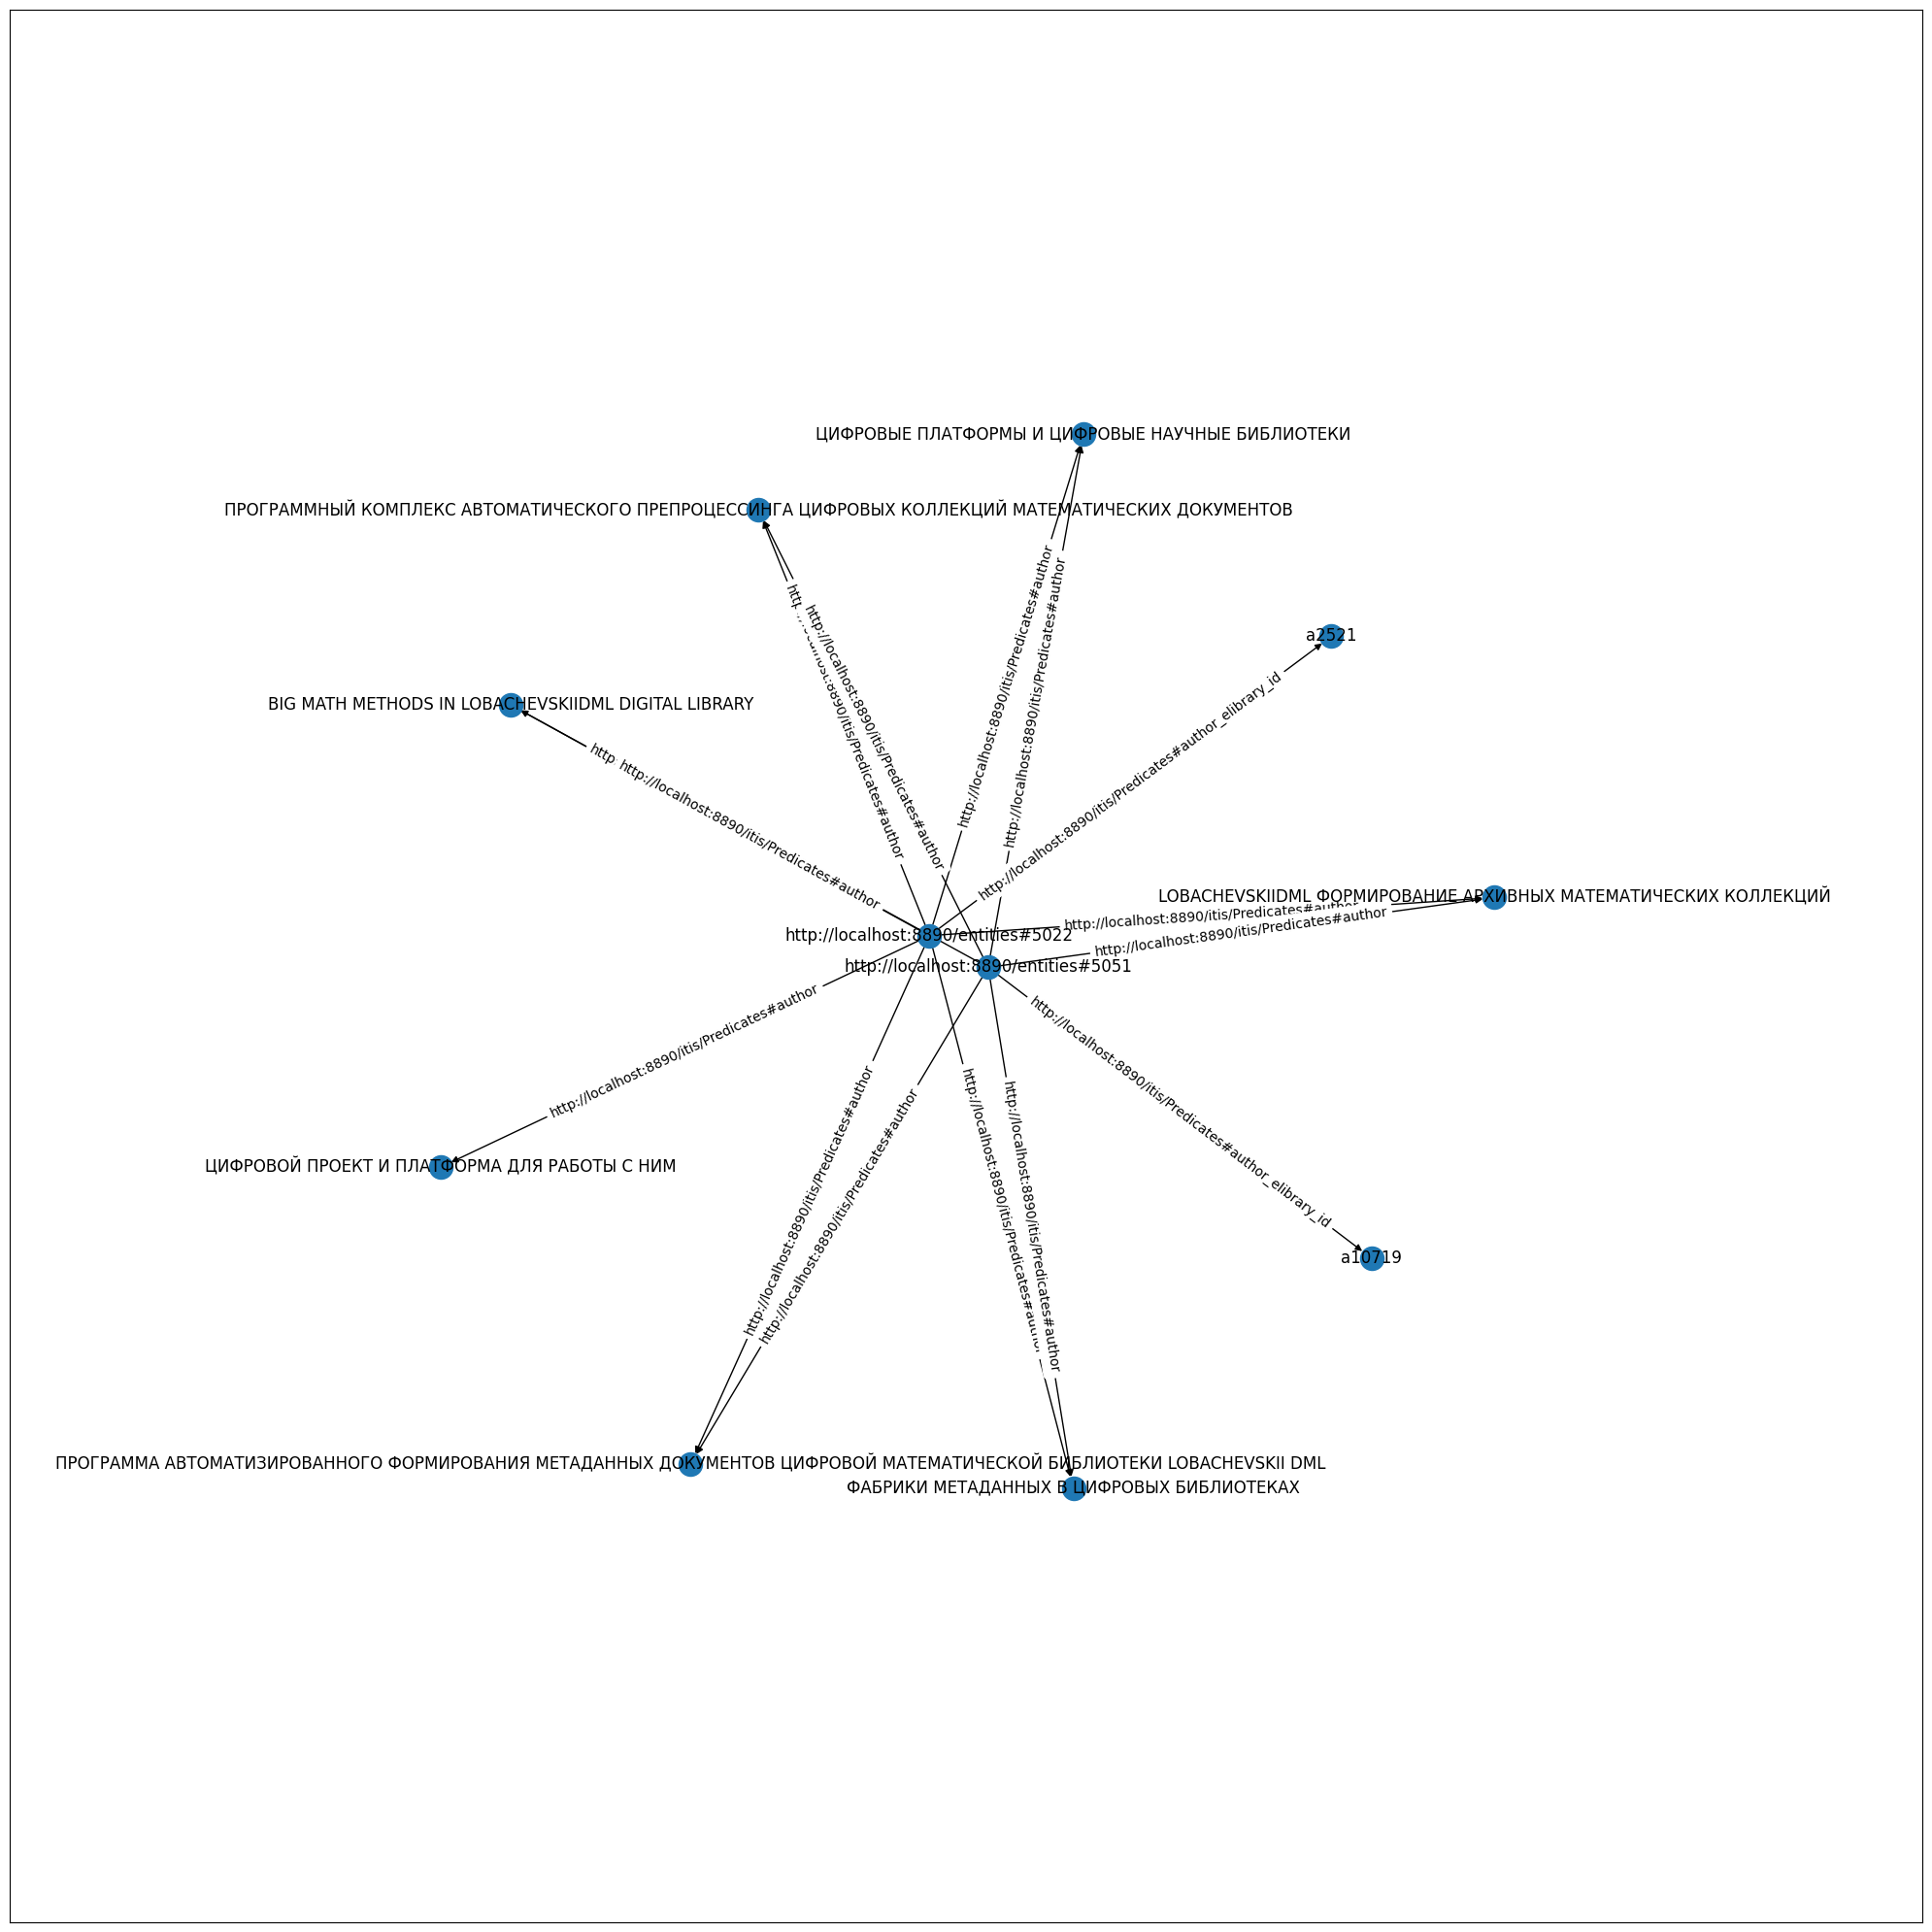

In [231]:
from lib.draw_graph import DrawGraph

dg = DrawGraph()
dg.graph_add(sel, True)
dg.draw_graph(20, 'graph.png')

Копирование существующего графа

In [5]:
gl.copy_graph('http://ontomathpro.org/omp2', f'{Environment._domain}/copy')

In [6]:
gl.commit()

In [17]:
a = sparql.select([TripleItemVariable('pers'), TripleItemVariable('name')], itis_graph_iri, [Triple(TripleItemVariable('pers'), TripleItemVariable('b'), TripleItemIri('http://xmlns.com/foaf/0.1/Person')), Triple(TripleItemVariable('pers'), TripleItemIri('http://xmlns.com/foaf/0.1/name'), TripleItemVariable('name'))])

In [ ]:
# sel = sparql.get_triples(['*'], 'http://localhost:8890/itis', [Triple(TripleItemVariable('author'), author_elibrary_id, TripleItemVariable('author_id')), 
#                                                                Triple(TripleItemVariable('author'), author_pred, TripleItemVariable('publication_id')),
#                                                                Triple(TripleItemVariable('author'), name, TripleItemStr('Елизаров Александр Михайлович')),
#                                                                Triple(TripleItemVariable('author2'), author_pred, TripleItemVariable('publication_id')),
#                                                                Triple(TripleItemVariable('author2'), author_elibrary_id, TripleItemVariable('author2_elibrary_id')),
#                                                                Triple(TripleItemVariable('author2'), name, TripleItemVariable('author2name')),
#                                                                Triple(TripleItemVariable('publication_id'), StandardPredicates._label, TripleItemVariable('pub_name'))])

WIKIDATA

In [ ]:
a = lib.wikidata_SPARQL.WikidataSPARQL.find_by_id("wd:Q82571", ['item', 'itemLabel', 'itemDescription'], {'wdt:P361' : 'partof'})
print(a)
a = lib.wikidata_SPARQL.WikidataSPARQL.find_by_label("linear algebra", ['item', 'itemLabel', 'itemDescription'], {'wdt:P361' : 'partof'})
print(a)
a = lib.wikidata_SPARQL.WikidataSPARQL.find_by_relations({'wdt:P2579': 'wd:Q82571', 'wdt:P31': 'wd:Q65943'}, ['item', 'itemLabel', 'itemDescription'], {'wdt:P2534' : 'formula'})
print(a)

In [ ]:
import graph_logic
gl = graph_logic.GraphLogic(v_SPARQL.VirtuosoSPARQLAuth('dba', 'dba'), v_SQL.VirtuosoSQL('dba', 'dba'))

In [ ]:
linear_alg_id = "wd:Q82571"
fields = ['item', 'itemLabel', 'itemDescription']
lin_al = lib.wikidata_SPARQL.WikidataSPARQL.find_by_id(linear_alg_id, fields)[0]

In [ ]:
fields = ['item', 'itemLabel', 'itemDescription']
res = lib.wikidata_SPARQL.WikidataSPARQL.find_by_label('linear algebra', fields)

In [ ]:
linear_alg_id = "wd:Q82571"
fields = ['item', 'itemLabel', 'itemDescription']
lin_al = lib.wikidata_SPARQL.WikidataSPARQL.find_by_id(linear_alg_id, fields)[0]
id_linal = gl.graph_get_or_create_node('math', Entities())

data = []

for key, value in lin_al.items():
    if key in fields:
        if key == 'item':
            gl.graph_add_triple('math', Triple(id_linal, StandardPredicates._wikidata_id, TripleItemStr(f"wd:{value['value'].split('/')[-1]}")))
        else:
            field = f'{key[4].lower()}{key[5:]}'
            if field == 'label':
                gl.graph_add_triple('math', Triple(id_linal, StandardPredicates._label, TripleItemStr(f"{value['value']}")))
            elif field == 'description':
                gl.graph_add_triple('math', Triple(id_linal, StandardPredicates._comment, TripleItemStr(f"{value['value']}")))

In [ ]:
gl.commit()

In [ ]:
studied_in = gl.graph_get_or_create_node('math', Predicates(iri=f'{Environment._domain}/math/studied_in'))

In [ ]:
linear_alg_id = "wd:Q82571"
fields = ['item', 'itemLabel', 'itemDescription']
lin_al_related = lib.wikidata_SPARQL.WikidataSPARQL.find_by_relations({'wdt:P2579': linear_alg_id}, ['item', 'itemLabel', 'itemDescription'])

for item in lin_al_related:
    new_r = gl.graph_get_or_create_node('math', Entities())
    for key, value in item.items():
        if key in fields:
            if key == 'item':
                gl.graph_add_triple('math', Triple(new_r, StandardPredicates._wikidata_id, TripleItemStr(f"wd:{value['value'].split('/')[-1]}")))
            else:
                field = f'{key[4].lower()}{key[5:]}'
                if field == 'label':
                    gl.graph_add_triple('math', Triple(new_r, StandardPredicates._label, TripleItemStr(f"{value['value']}")))
                elif field == 'description':
                    gl.graph_add_triple('math', Triple(new_r, StandardPredicates._comment, TripleItemStr(f"{value['value']}")))
    gl.graph_add_triple('math', Triple(new_r, studied_in, id_linal))

In [ ]:
gl.commit()